# от Бондаренко Алексея (bondaleksey@gmail.com)

Цель данного ноутбука провести моделирование распространения болезни по аэропортам и посмотреть некоторые функции библиотеки работы с графами NetworkX


Основные пункты исследования: 

* реализация функции моделирование распространения болезни,
* оценка скорости распространения болезни,
* исследование графа связности аэропортов и распространения болезни,
* заключение.

In [61]:
import numpy as np 
import pandas as pd

# for graphics 
import matplotlib.pyplot as plt
import seaborn as sns


#technical 
%matplotlib inline
import pickle
import warnings
import contextlib
import time

# 1. Данные

## 1.1 Описание признаков в наборе данных
Приведем [описание](https://docs.microsoft.com/en-us/machine-learning-server/r-reference/revoscaler/airlinedata87to08) набора [данных](https://www.kaggle.com/prajitdatta/data-stories-of-us-airlines) и 
**`выделим`** наиболее значимые признаки.

**Year** - year of the flight (stored as factor).

**Month** - month of the flight (stored as factor).

**`DayOfMonth`** - day of the month (1 to 31) (stored as integer).

**DayOfWeek** - day of the week (stored as factor).

**`DepTime`** - actual departure time (stored as float).

**`CRSDepTime`** - scheduled departure time (stored as float).

**`ArrTime`** - actual arrival time (stored as float).

**`CRSArrTime`** - scheduled arrival time (stored as float).

**UniqueCarrier** - carrier ID (stored as factor).

**FlightNum** - flight number (stored as factor).

**TailNum** - plane's tail number (stored as factor).

**`ActualElapsedTime`** - actual elapsed time of the flight, in minutes (stored as integer).

**CRSElapsedTime** - scheduled elapsed time of the flight, in minutes (stored as integer).

**AirTime** - airborne time for the flight, in minutes (stored as integer).

**ArrDelay** - arrival delay, in minutes (stored as integer).

**DepDelay** - departure delay, in minutes (stored as integer).

**`Origin`** - originating airport (stored as factor).

**`Dest`** - destination airport (stored as factor).

**Distance** - flight distance (stored as integer).

**TaxiIn** - taxi time from wheels down to arrival at the gate, in minutes (stored as integer).

**TaxiOut** - taxi time from departure from the gate to wheels up, in minutes (stored as integer).

**`Cancelled`** - cancellation status (stored as logical).

**CancellationCode** - cancellation code, if applicable (stored as factor).

**`Diverted`** - diversion status (stored as logical).

**CarrierDelay** - delay, in minutes, attributable to the carrier (stored integer).

**WeatherDelay** - delay, in minutes, attributable to weather factors (stored as integer).

**NASDelay** - delay, in minutes, attributable to the National Aviation System (stored as integer).

**SecurityDelay** - delay, in minutes, attributable to security factors (stored as integer).

**LateAircraftDelay** - delay, in minutes, attributable to late-arriving aircraft (stored as integer).

Для моделирования процесса распространения заболевания, требуется определение абсолютного времени взлета и посадки самолета для каждого рейса. Для этого будем использовать следующие признаки: 
DayOfMonth
Origin
Dest
Cancelled
Diverted

## 1.2. Чтение данных 

In [62]:
filename = "../data/airline_dec_2008_50k.csv"
df = pd.read_csv(filename, low_memory=False)
print(df.iloc[:3,:10])
print(df.iloc[:3,10:])

   Unnamed: 0  Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  \
0           1  2008     12           1          1      NaN        1000   
1           2  2008     12           1          1      NaN        1000   
2           3  2008     12           1          1      NaN        1000   

   ArrTime  CRSArrTime UniqueCarrier  
0      NaN        1100            WN  
1      NaN        1110            US  
2      NaN        1125            MQ  
   FlightNum TailNum  ActualElapsedTime  CRSElapsedTime  AirTime  ArrDelay  \
0         16  N366SW                NaN              60      NaN       NaN   
1       2122     NaN                NaN              70      NaN       NaN   
2       3155  N807MQ                NaN              85      NaN       NaN   

   DepDelay Origin Dest  Distance  TaxiIn  TaxiOut  Cancelled  \
0       NaN    HOU  DAL       239     NaN      NaN          1   
1       NaN    LGA  BOS       185     NaN      NaN          1   
2       NaN    SAN  SJC       417     N

In [63]:
print(df.shape)

(50000, 30)


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         50000 non-null  int64  
 1   Year               50000 non-null  int64  
 2   Month              50000 non-null  int64  
 3   DayofMonth         50000 non-null  int64  
 4   DayOfWeek          50000 non-null  int64  
 5   DepTime            32968 non-null  float64
 6   CRSDepTime         50000 non-null  int64  
 7   ArrTime            31418 non-null  float64
 8   CRSArrTime         50000 non-null  int64  
 9   UniqueCarrier      50000 non-null  object 
 10  FlightNum          50000 non-null  int64  
 11  TailNum            44556 non-null  object 
 12  ActualElapsedTime  31367 non-null  float64
 13  CRSElapsedTime     50000 non-null  int64  
 14  AirTime            31367 non-null  float64
 15  ArrDelay           31367 non-null  float64
 16  DepDelay           329

In [65]:
df.describe()

,Unnamed: 0,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,FlightNum,...,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,50000.000000,50000.0,50000.0,50000.000000,50000.000000,32968.000000,50000.000000,31418.000000,50000.000000,50000.000000,...,50000.000000,31418.000000,32458.000000,50000.000000,50000.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000
mean,25000.500000,2008.0,12.0,11.350900,3.695000,752.043102,978.930920,791.598829,1076.869720,2592.855480,...,572.158120,7.166879,16.336866,0.355580,0.017080,12.044503,2.584316,18.813327,0.152273,7.957662
std,14433.901067,0.0,0.0,7.843122,1.889499,364.602722,496.930255,193.315743,495.563167,2116.729997,...,446.647873,5.539380,9.846548,0.478693,0.129571,31.444616,13.186963,21.499273,2.125548,29.794825
min,1.000000,2008.0,12.0,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,...,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,12500.750000,2008.0,12.0,5.000000,2.000000,612.000000,630.000000,742.000000,805.000000,791.000000,...,261.000000,4.000000,10.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000
50%,25000.500000,2008.0,12.0,10.000000,4.000000,657.000000,735.000000,831.000000,910.000000,2021.000000,...,446.000000,6.000000,14.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000
75%,37500.250000,2008.0,12.0,17.000000,5.000000,750.000000,1300.000000,914.000000,1315.000000,4114.000000,...,733.000000,9.000000,20.000000,1.000000,0.000000,14.000000,0.000000,25.000000,0.000000,0.000000
max,50000.000000,2008.0,12.0,31.000000,7.000000,2400.000000,2359.000000,2359.000000,2359.000000,7829.000000,...,3303.000000,156.000000,206.000000,1.000000,1.000000,1092.000000,209.000000,326.000000,96.000000,336.000000


## 1.3  DataFrame с рейсами фактических перелетов между аэропортами

Если рейс был отменен или если рейс перенаправлен, то информацию о таких перелетах извлечем из рассмотрения при моделировании.
Наиболее простой способ это выделить только те рейсы в которых **ActualElapsedTime** не `NaN`

In [66]:
flights = df[df['ActualElapsedTime'].notna()][["Origin","Dest", "DayofMonth", "CRSDepTime", "CRSArrTime","DepTime", "ArrTime","Cancelled","Diverted", "DepDelay","ArrDelay","ActualElapsedTime"]]
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,Cancelled,Diverted,DepDelay,ArrDelay,ActualElapsedTime
17622,SLC,JFK,1,10,629,7.0,659.0,0,0,-3.0,30.0,292.0
17648,SLC,JFK,13,5,626,7.0,631.0,0,0,2.0,5.0,264.0
17666,SLC,JFK,14,5,626,3.0,634.0,0,0,-2.0,8.0,271.0
17700,SLC,JFK,15,5,626,2.0,602.0,0,0,-3.0,-24.0,240.0
18122,DFW,TUL,20,2310,5,3.0,58.0,0,0,53.0,53.0,55.0


Преобразуем столбцы некоторые признаки к типу данных int64

In [67]:
to_int_32_dict={"DepTime":"int64",
                "ArrTime":"int64",
                "DepDelay":"int64",
                "ActualElapsedTime":"int64"}

In [68]:
flights=flights.astype(to_int_32_dict)
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,Cancelled,Diverted,DepDelay,ArrDelay,ActualElapsedTime
17622,SLC,JFK,1,10,629,7,659,0,0,-3,30.0,292
17648,SLC,JFK,13,5,626,7,631,0,0,2,5.0,264
17666,SLC,JFK,14,5,626,3,634,0,0,-2,8.0,271
17700,SLC,JFK,15,5,626,2,602,0,0,-3,-24.0,240
18122,DFW,TUL,20,2310,5,3,58,0,0,53,53.0,55


Проверим, что нет `NaN` и нет отмененных и перенаправленных рейсов.

In [69]:
flights[["DepTime"]].isna().sum()

DepTime    0
dtype: int64

In [70]:
flights[["ArrTime"]].isna().sum()

ArrTime    0
dtype: int64

In [71]:
flights[["Cancelled"]].sum()

Cancelled    0
dtype: int64

In [72]:
flights[["Diverted"]].sum()

Diverted    0
dtype: int64

In [73]:
flights.shape

(31367, 12)

In [74]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31367 entries, 17622 to 49999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Origin             31367 non-null  object 
 1   Dest               31367 non-null  object 
 2   DayofMonth         31367 non-null  int64  
 3   CRSDepTime         31367 non-null  int64  
 4   CRSArrTime         31367 non-null  int64  
 5   DepTime            31367 non-null  int64  
 6   ArrTime            31367 non-null  int64  
 7   Cancelled          31367 non-null  int64  
 8   Diverted           31367 non-null  int64  
 9   DepDelay           31367 non-null  int64  
 10  ArrDelay           31367 non-null  float64
 11  ActualElapsedTime  31367 non-null  int64  
dtypes: float64(1), int64(9), object(2)
memory usage: 3.1+ MB


In [75]:
flights.describe()

,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,Cancelled,Diverted,DepDelay,ArrDelay,ActualElapsedTime
count,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.0,31367.0,31367.000000,31367.000000,31367.000000
mean,7.209488,739.032231,800.524437,715.190806,791.311984,0.0,0.0,1.124940,0.342813,109.631555
std,4.686065,331.297472,210.604854,314.193024,192.926966,0.0,0.0,20.289293,24.317448,54.238003
min,1.000000,5.000000,1.000000,1.000000,1.000000,0.0,0.0,-28.000000,-71.000000,25.000000
25%,3.000000,614.000000,745.000000,610.000000,742.000000,0.0,0.0,-5.000000,-11.000000,71.000000
50%,7.000000,700.000000,835.000000,654.000000,831.000000,0.0,0.0,-3.000000,-4.000000,97.000000
75%,10.000000,740.000000,915.000000,740.000000,914.000000,0.0,0.0,0.000000,5.000000,135.000000
max,31.000000,2359.000000,2359.000000,2400.000000,2359.000000,0.0,0.0,1092.000000,1103.000000,457.000000


In [76]:
flights=flights.drop(columns=["Cancelled","Diverted"]);

In [77]:
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay,ActualElapsedTime
17622,SLC,JFK,1,10,629,7,659,-3,30.0,292
17648,SLC,JFK,13,5,626,7,631,2,5.0,264
17666,SLC,JFK,14,5,626,3,634,-2,8.0,271
17700,SLC,JFK,15,5,626,2,602,-3,-24.0,240
18122,DFW,TUL,20,2310,5,3,58,53,53.0,55


 ## 1.4 Определим фактическое время вылета

Для определения абсолютного времени, нам необходимо узнать смещение локального времени аэропорта относительно GMT времени. Для этого используем результаты [открытого проекта](https://github.com/opentraveldata/opentraveldata/blob/master/opentraveldata/optd_por_public.csv),
а сам файл с информацией об открытых аэропортах(11Mb) доступен по [ссылке](https://raw.githubusercontent.com/opentraveldata/opentraveldata/master/opentraveldata/optd_por_public.csv).
Для дополнительной можно использовать сервис, где информация об YUM выдается по [запросу](https://airports-api.s3-us-west-2.amazonaws.com/iata/yum.json).

Результаты для аэропортов из `flights` получены скриптом **prepare_gtm_offset.py** и сохранены в словаре в файле  "..\data\airports_gmt_offset_int.pkl" .

In [78]:
with open('../data/airports_gmt_offset_int.pkl','rb') as f:
    airport_time_offset = pickle.load(f)

In [79]:
for key, val in airport_time_offset.items():
    if key<"B":
        print(f"Key = {key} : val = {val}")                

Key = ABE : val = -5
Key = ABI : val = -6
Key = ABQ : val = -7
Key = ABY : val = -5
Key = ACT : val = -6
Key = ACV : val = -8
Key = ADQ : val = -9
Key = AEX : val = -6
Key = AGS : val = -5
Key = ALB : val = -5
Key = AMA : val = -6
Key = ANC : val = -9
Key = ASE : val = -7
Key = ATL : val = -5
Key = ATW : val = -6
Key = AUS : val = -6
Key = AVL : val = -5
Key = AVP : val = -5
Key = AZO : val = -5


Дополним таблицу `flights` столбцом абсолютного времени вылета в минутах по отношению к 1 декабря GMT(0-00) 2008 года.

In [80]:
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay,ActualElapsedTime
17622,SLC,JFK,1,10,629,7,659,-3,30.0,292
17648,SLC,JFK,13,5,626,7,631,2,5.0,264
17666,SLC,JFK,14,5,626,3,634,-2,8.0,271
17700,SLC,JFK,15,5,626,2,602,-3,-24.0,240
18122,DFW,TUL,20,2310,5,3,58,53,53.0,55


Так как у вылета при изменении времени вылета изменений в его фактическом дне вылета не происходит, то для расчетов абсолютных  времен вылета и прилета надо пользоваться:
- DayofMonth
- CRSDepTime/CRSArrTime
- DepDelay/ArrDelay

Но так как может быть ночной перелет, то надо к фактическому времени вылета добавить время на полет

In [81]:
# Определим функции  вычисления длительности полета 
def gtm_time_dep(airport, day, crs, delay):
    """Calculate gmt time of departure in minutes according data format"""
    return (day-1)*24*60 + int(crs/100)*60 + crs%100 + delay + airport_time_offset[airport]*60

def gtm_time_arr(gtmDep, eltime ):
    """Calculate gmt time of arrival in minutes according data format"""
    return gtmDep + eltime

In [82]:
flights["gtm_origin"] = flights.apply(lambda x: airport_time_offset[x.Origin], axis=1)
flights["gtm_dest"] = flights.apply(lambda x: airport_time_offset[x.Dest], axis=1)

In [83]:
flights["gmtDep"] = flights.apply(lambda x: gtm_time_dep(x.Origin, x.DayofMonth, x.CRSDepTime, x.DepDelay), axis=1)

In [84]:
flights["gmtArr"] = flights["gmtDep"]+flights["ActualElapsedTime"]
#flights.apply(lambda x: gtm_time_arr(x.gmtDep, x.ActualElapsedTime), axis=1)

Отсортируем данные по дням и времени вылета

In [85]:
flights=flights.sort_values(by=["gmtDep"])

In [86]:
flights.head()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay,ActualElapsedTime,gtm_origin,gtm_dest,gmtDep,gmtArr
18609,ANC,SEA,1,30,449,28,440,-2,-9.0,192,-9,-8,-512,-320
18854,ANC,PDX,1,100,532,56,514,-4,-18.0,198,-9,-8,-484,-286
19409,ANC,SLC,1,110,743,108,744,-2,1.0,276,-9,-7,-472,-196
18606,LAX,MSP,1,20,553,16,616,-4,23.0,240,-8,-6,-464,-224
18610,SFO,MSP,1,25,556,30,611,5,15.0,221,-8,-6,-450,-229


In [87]:
flights.tail()

,Origin,Dest,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay,ActualElapsedTime,gtm_origin,gtm_dest,gmtDep,gmtArr
24710,IAD,MCO,31,2155,9,2224,26,29,17.0,122,-5,-5,44244,44366
24713,DFW,AUS,31,2325,20,2327,9,2,-11.0,42,-6,-6,44247,44289
24707,SJU,JFK,31,2100,1,2145,53,45,52.0,248,-4,-5,44265,44513
19223,ORD,BUF,31,2141,15,3,237,142,142.0,94,-6,-5,44283,44377
24712,JFK,ROC,31,2235,1,2327,35,52,34.0,68,-5,-5,44307,44375


## 1.5  Рассмотрим подробнее очищенные данные

In [88]:
flights.describe()

,DayofMonth,CRSDepTime,CRSArrTime,DepTime,ArrTime,DepDelay,ArrDelay,ActualElapsedTime,gtm_origin,gtm_dest,gmtDep,gmtArr
count,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.000000,31367.00000,31367.000000
mean,7.209488,739.032231,800.524437,715.190806,791.311984,1.124940,0.342813,109.631555,-6.149456,-6.208882,9026.22852,9135.860076
std,4.686065,331.297472,210.604854,314.193024,192.926966,20.289293,24.317448,54.238003,1.276300,1.234447,6776.72387,6783.911373
min,1.000000,5.000000,1.000000,1.000000,1.000000,-28.000000,-71.000000,25.000000,-10.000000,-10.000000,-512.00000,-320.000000
25%,3.000000,614.000000,745.000000,610.000000,742.000000,-5.000000,-11.000000,71.000000,-7.000000,-7.000000,3583.00000,3752.500000
50%,7.000000,700.000000,835.000000,654.000000,831.000000,-3.000000,-4.000000,97.000000,-6.000000,-6.000000,8703.00000,8805.000000
75%,10.000000,740.000000,915.000000,740.000000,914.000000,0.000000,5.000000,135.000000,-5.000000,-5.000000,13105.00000,13229.000000
max,31.000000,2359.000000,2359.000000,2400.000000,2359.000000,1092.000000,1103.000000,457.000000,-4.000000,-4.000000,44307.00000,44513.000000


### 1.5.1 Длительность полета

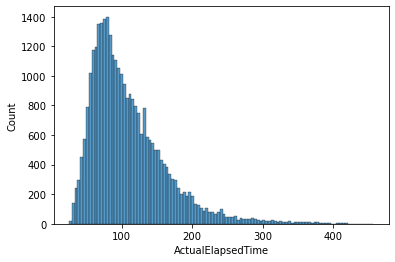

In [89]:
sns.histplot(flights["ActualElapsedTime"]);
#sns.distplot
#histplot
#displot

### 1.5.2 Посмотреть число рейсов по дням

In [90]:
number_of_flights_per_day = [ (flights["DayofMonth"]==i).sum() for i in range(1,32,1)]

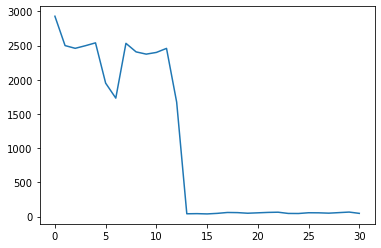

In [91]:
plt.plot(number_of_flights_per_day);

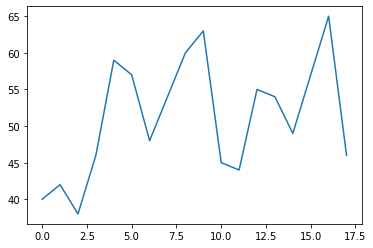

In [92]:
plt.plot(number_of_flights_per_day[13:]);

# 2. Моделирование распространения болезни между аэропортами

## 2.1 DataFrame для модулирования

Для дальнейшей работы нам достаточно столбцов:
- Аэропорты вылета(**Origin**) и прилета(**Dest**),
- абсолютное время в минутах вылета (**gmtDep**) и посадки(**gmtArr**) 

In [93]:
df4sim = flights[['Origin','Dest','gmtDep','gmtArr']].copy()

In [94]:
df4sim.head()

,Origin,Dest,gmtDep,gmtArr
18609,ANC,SEA,-512,-320
18854,ANC,PDX,-484,-286
19409,ANC,SLC,-472,-196
18606,LAX,MSP,-464,-224
18610,SFO,MSP,-450,-229


## 2.2 Функция моделирования (симуляции) одного прохода по всему списку перелетов

In [136]:
def one_simulation(df, contagious=0.5, start="All"):
    """_summary_

    Args:
        df (_type_): _description_
        contagious (float, optional): _description_. Defaults to 0.5.
        start (str, optional): _description_. Defaults to "All".
    """        
    # we have set of airports which will be contagious when flight arrives
    
    
    # history - is a dictionary with
    # airport : time when it became contagious
    ill=set()
    i = 0
    if start=="All":
        ill.add(df.Origin.iloc[0])
        history = {df.Origin.iloc[0]: df.gmtDep.iloc[0]}
    else:        
        ill.add(df.Origin[df.Origin == start].iloc[0])
        history = {df.Origin[df.Origin == start].iloc[0]: df.gmtDep[df.Origin == start].iloc[0]}
        print(df[df.Origin == start].iloc[0])
    print(history, ill)
    
    for row in df.itertuples():
        if (row.Origin in ill) and (row.Dest not in ill):            
            if np.random.random()<contagious:
                ill.add(row.Dest)
                history[row.Dest] = row.gmtArr
                            
        if i>10:
            break
        i+=1
    
    print(ill)
    print(history)
    # i = 0
    # for row in df.itertuples():
    #     print(row.Origin)
    #     print(row.Dest)        
    #     print(row.gmtDep)
    #     print(row.gmtArr)
        
    #     if i>2:
    #         break
    #     i+=1

# We will analyse in other function, so give back that you like to give!!! 

In [142]:
np.random.seed(3047)
print(np.random.random(10))
one_simulation(df4sim,0.2)

[0.12773252 0.11345864 0.97339125 0.09913118 0.06825584 0.81968653
 0.36352503 0.5016449  0.34201792 0.88911885]
{'ANC': -512} {'ANC'}
{'SLC', 'SEA', 'ANC', 'PDX'}
{'ANC': -512, 'SEA': -320, 'PDX': -286, 'SLC': -196}


In [141]:
df4sim.head(10)

,Origin,Dest,gmtDep,gmtArr
18609,ANC,SEA,-512,-320
18854,ANC,PDX,-484,-286
19409,ANC,SLC,-472,-196
18606,LAX,MSP,-464,-224
18610,SFO,MSP,-450,-229
18611,SMF,IAH,-446,-242
19414,ANC,SEA,-446,-252
18612,SFO,IAH,-445,-251
18613,LAS,JFK,-442,-134
18615,SEA,MSP,-437,-249


# 3. Исследование графа связности аэропортов и распространения болезни

сделать индексами аэропорты вылета и прилета 
set_index ([,]) а потом еще сделать группировку по этим данным 

делая группировку, мы будем складывать число строк ... 
А как быть с обратным вылетом??? или как удалить их ??? 

FG = nx.Graph()
FG.add_weighted_edges_from([(1, 2, 0.125), (1, 3, 0.75), (2, 4, 1.2), (3, 4, 0.375)])

Что нам надо, чтобы посчитать ненаправленный граф всех аэропортов - число перелетов между аэропортами 
+ вес вершины = медианное время на заражение
вершины = названия аэропортов
связи = то где были полеты 
словарь "nodes": список вершин, где каждая вершина это словарь, а потом еще "links": лист связей=ребер 

{
  "nodes": [
    {
      "name": "QUI-GON",
      "value": 61,
      "colour": "#4f4fb1"
    },
    {
      "name": "NUTE GUNRAY",
      "value": 24,
      "colour": "#808080"
    }
  ],    
   "links": [
    {
      "source": 1,
      "target": 0,
      "value": 1
    },
    {
      "source": 2,
      "target": 3,
      "value": 1
    }
   ]
}
